In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import RobustScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from keras.layers import Input, Dense, concatenate
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.losses import mean_absolute_percentage_error
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# dataset_directory = Path('/kaggle/input/amp-parkinsons-disease-progression-prediction')
train_clinical_df = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
train_peptide_df = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_protein_df = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
supp_df = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")
print("Training size for clinical data: ",train_clinical_df.shape)
print("Training size for peptides data: ",train_peptide_df.shape)
print("Training size for proteins data: ",train_protein_df.shape)
print("Training size for supplemental clinical data: ",supp_df.shape)

Training size for clinical data:  (2615, 8)
Training size for peptides data:  (981834, 6)
Training size for proteins data:  (232741, 5)
Training size for supplemental clinical data:  (2223, 8)


In [ ]:
clinical_df = train_clinical_df.copy()

nan_counts = clinical_df.isna().sum()

print("Train_Clinical_df:")
print("(Rows, Columns):", clinical_df.shape)
print("Number of NAN in each column:")
print(nan_counts)

Train_Clinical_df:
(Rows, Columns): (2615, 8)
Number of NAN in each column:
visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64


In [ ]:
clinical_df = supp_df.copy()

nan_counts = clinical_df.isna().sum()

print("Train_Clinical_df:")
print("(Rows, Columns):", clinical_df.shape)
print("Number of NAN in each column:")
print(nan_counts)

Train_Clinical_df:
(Rows, Columns): (2223, 8)
Number of NAN in each column:
visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 213
updrs_2                                 214
updrs_3                                   5
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
dtype: int64


1. As shown in above, there are 1038/2615 rows in Train_clinical_df have missing values. In order to make use of all the information given in the train_clinical_df, we will use KNN imputation to fill the missing values.
2. We merge the complete records (no missing values) from Supplementary_clinical_df to Train_clinical_df to augment the clinical dataset aiming to improve the performance of KNN imputation.
3. Apply x = log (x+1) to transform the data into normal distribution like data. This can also improve the KNN imputation performance.

1. remove rows with missing values in Supp_df in the specified columns (updrs_1, updrs_2, updrs_3, updrs_4)
2. remove the column 'upd23b_clinical_state_on_medication' from both clinical dataset  as the information is not considered in the test dataset in this competition.

## To analyze the trend in the visit_month column of the DataFrame, we plot a line graph of the average UPDRS scores (i.e., updrs_1, updrs_2, updrs_3, and updrs_4) against the visit_month.

* We can compare the trends of three figures using the cleaned dataset, the cleaned dataset filtered by medication "ON", and the cleaned dataset filtered by medication "OFF".

Text(0.5, 1.0, 'Medication = "OFF",\n # of samples: 542')

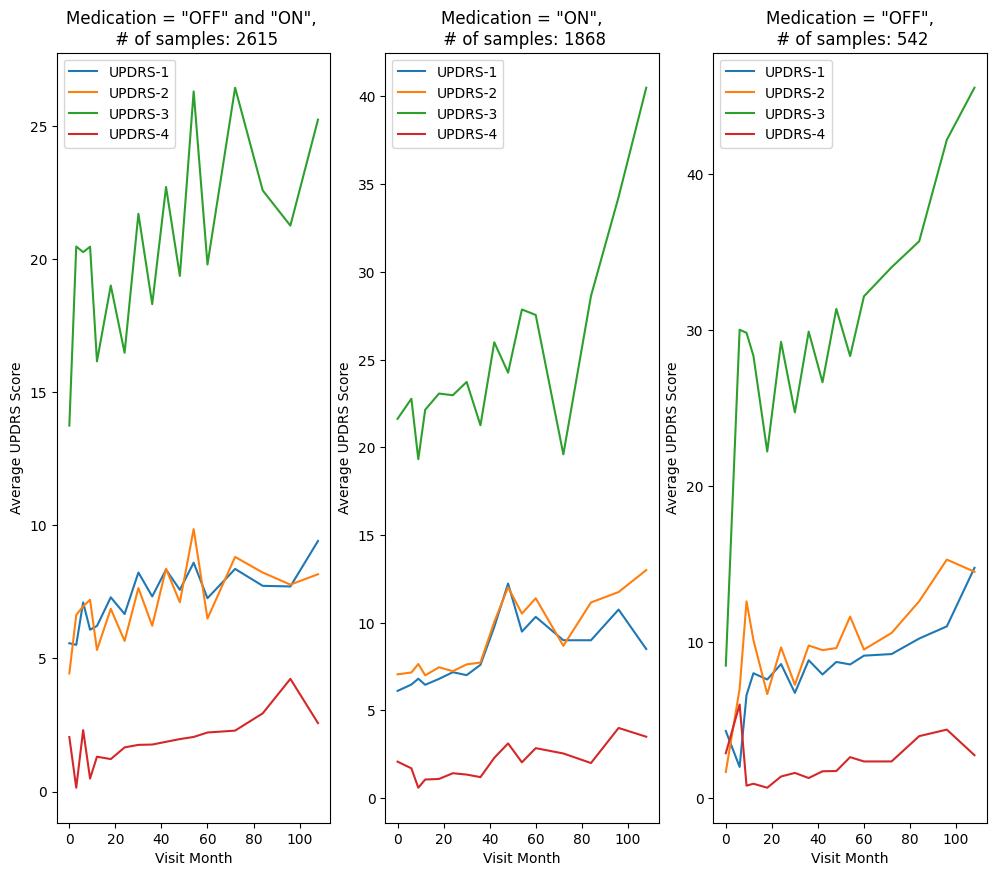

In [ ]:
# create three subplots in rows
fig, ax = plt.subplots(ncols = 3,  figsize=(12, 10))

# Ignore rows with NaN values in updrs_1, updrs_2, updrs_3, and updrs_4
df = train_clinical_df#[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'visit_month']].dropna()

# Group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = df.groupby('visit_month').mean()

# Plot the line graph of the average UPDRS scores against visit_month
ax[0].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[0].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[0].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[0].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[0].set_xlabel('Visit Month')
ax[0].set_ylabel('Average UPDRS Score')
ax[0].legend()
ax[0].set_title('Medication = "OFF" and "ON", \n # of samples: {}'.format(df.shape[0]))



# "upd23b_clinical_state_on_medication"] == "On"
# concatenate the two DataFrames vertically
df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
on_medication_df = df[df["upd23b_clinical_state_on_medication"] == "On"]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = on_medication_df.iloc[:, :-1].groupby('visit_month').mean()

# plot the line graph of the average UPDRS scores against visit_month
ax[1].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[1].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[1].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[1].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[1].set_xlabel('Visit Month')
ax[1].set_ylabel('Average UPDRS Score')
ax[1].legend()
ax[1].set_title('Medication = "ON",\n # of samples: {}'.format(on_medication_df.shape[0]))


# "upd23b_clinical_state_on_medication"] == "OFF"
# concatenate the two DataFrames vertically
df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
on_medication_df = df[df["upd23b_clinical_state_on_medication"] == "Off"]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = on_medication_df.iloc[:, :-1].groupby('visit_month').mean()

# plot the line graph of the average UPDRS scores against visit_month
ax[2].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[2].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[2].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[2].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[2].set_xlabel('Visit Month')
ax[2].set_ylabel('Average UPDRS Score')
ax[2].legend()
ax[2].set_title('Medication = "OFF",\n # of samples: {}'.format(on_medication_df.shape[0]))

In [ ]:
# Dropping the upd23b_clinical_state_on_medication column from both sup_df and train_clinical_df
supp_df.drop(supp_df.columns[-1], axis=1, inplace = True)
train_clinical_df.drop(train_clinical_df.columns[-1],axis=1,inplace = True)

# Dropping the NaN values from the updrs_1, updrs_2, updrs_3, updrs_4
supp_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], inplace=True)

print("The Shape of the train_clinical_df is:",train_clinical_df.shape)
print("The Shape of the supp_df is:",supp_df.shape)

The Shape of the train_clinical_df is: (2615, 7)
The Shape of the supp_df is: (1277, 7)


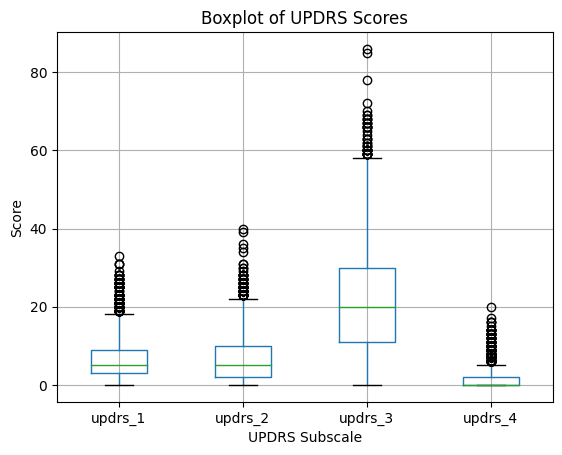

In [ ]:
cols = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
df[cols].boxplot()
plt.title('Boxplot of UPDRS Scores')
plt.xlabel('UPDRS Subscale')
plt.ylabel('Score')
plt.show()

In [ ]:
# concatenate the two train_clinical_df and supp_df vertically
train_df = pd.concat([train_clinical_df, supp_df], ignore_index=True)

In [ ]:
cols_to_normalize = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
train_df[cols_to_normalize] = np.log1p(train_df[cols_to_normalize])

In [ ]:
# perform KNN imputation on the normalized data
# Impute missing values in the last 4 columns
imputer = KNNImputer(n_neighbors=15)
train_df[cols_to_normalize] = np.maximum(imputer.fit_transform(train_df[cols_to_normalize]),0)
train_df[cols_to_normalize]=np.maximum(np.expm1(train_df[cols_to_normalize]),0)
train_df = train_df.head(n= 2615)
train_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,1.495630
1,55_3,55,3,10.0,7.0,25.0,0.791799
2,55_6,55,6,8.0,10.0,34.0,1.295668
3,55_9,55,9,8.0,9.0,30.0,0.000000
4,55_12,55,12,10.0,10.0,41.0,0.000000
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.000000
2611,65043_54,65043,54,4.0,8.0,11.0,1.000000
2612,65043_60,65043,60,6.0,6.0,16.0,1.000000
2613,65043_72,65043,72,3.0,9.0,14.0,1.000000


> Columns specified in cols_to_normalize in train_df DataFrame are transformed using the inverse of the natural logarithm plus one (expm1). The expm1 function calculates the exponential of each element in the specified columns minus one, which is equivalent to the log1p function in reverse. If the values are negative, they are set to 0 element-wise. In certain types of analyses and modeling, this transformation is often used to reduce the impact of outliers and to bring the range of values closer together.

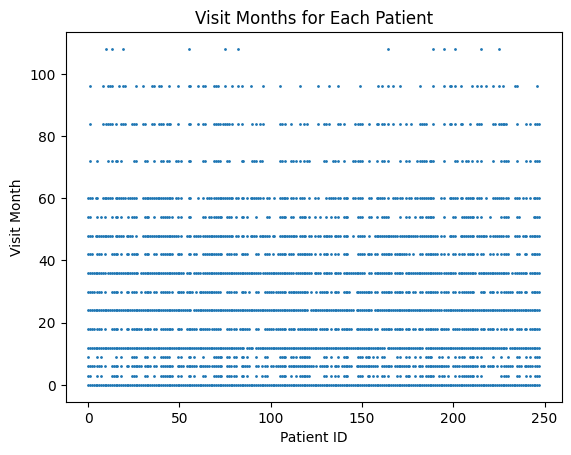

In [ ]:
df = train_df.copy(deep=True)
df['patient_index'] = df.groupby('patient_id').ngroup()

# create a scatter plot for patient_index versus visit_month
plt.scatter(df['patient_index'], df['visit_month'], s=1)

#plt.scatter(df_new_index.index, df_new_index["visit_month"], s=1)
plt.xlabel("Patient ID")
plt.ylabel("Visit Month")
plt.title("Visit Months for Each Patient")

# display the plot
plt.show()

* **From the figure above, we get to know that, most patients have records for up to 60 months, and after that, the data becomes sparse, i.e., there are fewer patients with records beyond 60 months. Therefore, for our analysis, we will only consider the data from the 60 months prior.**
* **Since we want to predict the target for the next 6, 12 months, we need to include data up to 72 months to get as much information as possible for our training dataset.**

In [ ]:
train_df = train_df.rename(columns={
    'updrs_1': 'updrs_1_plus_0_months',
    'updrs_2': 'updrs_2_plus_0_months',
    'updrs_3': 'updrs_3_plus_0_months',
    'updrs_4': 'updrs_4_plus_0_months'
})
train_df

,visit_id,patient_id,visit_month,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months
0,55_0,55,0,10.0,6.0,15.0,1.495630
1,55_3,55,3,10.0,7.0,25.0,0.791799
2,55_6,55,6,8.0,10.0,34.0,1.295668
3,55_9,55,9,8.0,9.0,30.0,0.000000
4,55_12,55,12,10.0,10.0,41.0,0.000000
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.000000
2611,65043_54,65043,54,4.0,8.0,11.0,1.000000
2612,65043_60,65043,60,6.0,6.0,16.0,1.000000
2613,65043_72,65043,72,3.0,9.0,14.0,1.000000


In [ ]:
ts_df_updrs = pd.DataFrame(columns=['time', 'patient_id',  'visit_id',
                                    'updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                                    'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                                    'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                                    'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months'
                                    ])

In [ ]:
for patient_id in train_df['patient_id'].unique():
    p_df = train_df[train_df['patient_id']==patient_id]
    ts_start = p_df.visit_month.min()
    ts_end = p_df.visit_month.max()
    ts_span = ts_end - ts_start
    p_num = p_df.shape[0]
    if (p_num > 1) and (ts_span >= 30) and (ts_span/(p_df.shape[0]-1) < 24):
        if ts_end > 72:
            ts_end = 72+1

        patient_df = pd.DataFrame({'time': range(ts_start, ts_end, 6), 'patient_id': patient_id})
        patient_df['visit_id'] = patient_df['patient_id'].astype(str) + '_' + patient_df['time'].astype(str)
        merged_df = pd.merge(patient_df, p_df, on='visit_id', how='left')
        merged_df.drop('patient_id_y', axis=1, inplace=True)
        merged_df.rename(columns={'patient_id_x': 'patient_id'}, inplace=True)
        merged_df = merged_df.fillna(method='ffill')
        updrs_cols = ['updrs_1_plus_0_months', 'updrs_2_plus_0_months', 'updrs_3_plus_0_months', 'updrs_4_plus_0_months']
        merged_df[['updrs_1_plus_6_months', 'updrs_2_plus_6_months', 'updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                   'updrs_1_plus_12_months', 'updrs_2_plus_12_months', 'updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                   'updrs_1_plus_24_months', 'updrs_2_plus_24_months', 'updrs_3_plus_24_months', 'updrs_4_plus_24_months']] = \
                  merged_df[updrs_cols].shift(-1).iloc[:, :4].join(merged_df[updrs_cols].shift(-2).iloc[:, :4], rsuffix='_plus_12_months') \
                  .join(merged_df[updrs_cols].shift(-4).iloc[:, :4], rsuffix='_plus_24_months')
        merged_df = merged_df.drop('visit_month', axis=1).dropna()
        ts_df_updrs = pd.concat([ts_df_updrs, merged_df], ignore_index=True)

In [ ]:
ts_df_updrs

,time,patient_id,visit_id,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months,updrs_1_plus_6_months,updrs_2_plus_6_months,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,0,55,55_0,10.0,6.0,15.00000,1.495630,8.0,10.0,34.0,1.295668,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,6,55,55_6,8.0,10.0,34.00000,1.295668,10.0,10.0,41.0,0.000000,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
2,12,55,55_12,10.0,10.0,41.00000,0.000000,7.0,13.0,38.0,0.000000,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
3,18,55,55_18,7.0,13.0,38.00000,0.000000,16.0,9.0,49.0,0.000000,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
4,24,55,55_24,16.0,9.0,49.00000,0.000000,14.0,13.0,49.0,0.000000,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,24,65043,65043_24,4.0,8.0,17.70283,0.000000,3.0,4.0,4.0,0.000000,2.0,7.0,5.0,0.0,7.0,6.0,13.0,0.0
1599,30,65043,65043_30,3.0,4.0,4.00000,0.000000,2.0,7.0,5.0,0.000000,9.0,10.0,15.0,0.0,4.0,8.0,11.0,1.0
1600,36,65043,65043_36,2.0,7.0,5.00000,0.000000,9.0,10.0,15.0,0.000000,7.0,6.0,13.0,0.0,6.0,6.0,16.0,1.0
1601,42,65043,65043_42,9.0,10.0,15.00000,0.000000,7.0,6.0,13.0,0.000000,4.0,8.0,11.0,1.0,6.0,6.0,16.0,1.0


# Part II. Extract features from Proteins and Peptides

## Join Protein and Peptide on 'visit_id','UniProt'

In [ ]:
Prot_Peptides_df = pd.merge(train_protein_df, train_peptide_df, on = ['visit_id','UniProt'], how = 'left')
Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','NPX','Peptide','PeptideAbundance']]
Prot_Peptides_df

,visit_id,UniProt,NPX,Peptide,PeptideAbundance
0,55_0,O00391,11254.3,NEQEQPLGQWHLS,11254.30
1,55_0,O00533,732430.0,GNPEPTFSWTK,102060.00
2,55_0,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00
3,55_0,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,O00533,732430.0,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...
981829,58648_108,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00
981830,58648_108,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00
981831,58648_108,Q9Y646,21257.6,LALLVDTVGPR,21257.60
981832,58648_108,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [ ]:
Prot_Peptides_df.isna().sum().sum()

0

## Select a subset of UniProt, which are shared in all visit_id sample.

In [ ]:
# group by visit_id and get the set of unique UniProt values for each group
grouped = Prot_Peptides_df.groupby('visit_id')['UniProt'].apply(set)

# initialize the intersection set with the UniProt values from the first group
intersection = set(grouped.iloc[0])

# iterate through the remaining groups and update the intersection set
for group in grouped.iloc[1:]:
    intersection = intersection.intersection(group)

# print the intersection
print(intersection, len(intersection))

{'P23142', 'P01023', 'P02787', 'P01024', 'P05090', 'Q12805', 'P01834', 'P02749', 'P10909', 'P02765', 'P01011', 'P01876', 'P02774', 'P06396', 'P02751', 'P01042', 'Q9UHG2', 'O15240', 'P02768', 'P02790', 'P01009', 'P02649', 'P02647', 'P41222', 'Q92520', 'P02766', 'P07602'} 27


* Among all samples, there are 27 UniProt entries that are present.
* Select the 27 UniProt as features and filter the Prot_Peptides_df to have the intersection.

In [ ]:
# set of UniProt values to select
uniprots_to_select = intersection

# filter the dataframe to select rows with UniProt values in the set
df_filtered = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select)]

# print the resulting dataframe
print(df_filtered)

         visit_id UniProt         NPX          Peptide  PeptideAbundance
15           55_0  O15240    177775.0      AYQGVAAPFPK         107076.00
16           55_0  O15240    177775.0     QQETAAAETETR           3095.35
17           55_0  O15240    177775.0     THLGEALAPLSK          67603.70
94           55_0  P01009  14415900.0          FLENEDR          41501.10
95           55_0  P01009  14415900.0         FLENEDRR          46973.10
...           ...     ...         ...              ...               ...
981797  58648_108  Q92520    907400.0         SPFEQHIK          66357.20
981826  58648_108  Q9UHG2    369437.0     AEAQEAEDQQAR           7884.17
981827  58648_108  Q9UHG2    369437.0   ARAEAQEAEDQQAR          80542.00
981828  58648_108  Q9UHG2    369437.0     GEAAGAVQELAR          78191.40
981829  58648_108  Q9UHG2    369437.0  ILAGSADSEGVAAPR         202820.00

[424373 rows x 5 columns]


Data processing for NPX

In [ ]:
df_filtered[['PeptideAbundance']] = df_filtered[['PeptideAbundance']].apply(lambda x: np.log1p(x))

# standardization
scaler1 = StandardScaler()
df_filtered[['PeptideAbundance']] = scaler1.fit_transform(df_filtered[['PeptideAbundance']])

In [ ]:
df_filtered

,visit_id,UniProt,NPX,Peptide,PeptideAbundance
15,55_0,O15240,177775.0,AYQGVAAPFPK,-0.253525
16,55_0,O15240,177775.0,QQETAAAETETR,NaN
17,55_0,O15240,177775.0,THLGEALAPLSK,-0.721100
94,55_0,P01009,14415900.0,FLENEDR,-1.673275
95,55_0,P01009,14415900.0,FLENEDRR,-1.338802
...,...,...,...,...,...
981797,58648_108,Q92520,907400.0,SPFEQHIK,-0.745227
981826,58648_108,Q9UHG2,369437.0,AEAQEAEDQQAR,NaN
981827,58648_108,Q9UHG2,369437.0,ARAEAQEAEDQQAR,-0.517749
981828,58648_108,Q9UHG2,369437.0,GEAAGAVQELAR,-0.549487


In [ ]:
# create a list of all peptides in the original data
all_peptides = df_filtered['Peptide'].unique()
all_visit_id = df_filtered['visit_id'].unique()

pca = PCA(n_components = 10)

# initialize an empty list to store the PCA features
pca_features_list = []

for visit_id in all_visit_id:
    # Part 1: construct UniProt-Peptide Network for each visit_id
    p_df = df_filtered[df_filtered['visit_id'] == visit_id]
    # first, pivot the data so that the UniProt column becomes the index,
    # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
    pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
    # iterate over each UniProt and add missing peptides as columns with a value of 0
    for prot in pivoted.index:
        missing_peptides = set(all_peptides) - set(pivoted.columns)
        for pep in missing_peptides:
            pivoted.loc[prot, pep] = 0

    # fill any remaining missing values with 0
    pivoted.fillna(0, inplace=True)
    # reset the index so that UniProt is a column again
    pivoted = pivoted.reset_index()
    # rename the index column to 'UniProt'
    pivoted.index.name = 'UniProt'
    # save the pivoted DataFrame to a new variable called `new_df`
    new_df = pivoted.copy(deep=True)

    # Part II: PCA feature extraction
    # fit and transform the data
    df1_pca = pca.fit_transform(new_df.iloc[:,1:])
    # flatten the array to one dimension
    df1_pca = np.array(df1_pca).flatten()
    # store the PCA features along with the visit_id in the list
    pca_features_list.append({'visit_id': visit_id, 'pca_features': df1_pca})

# construct a dataframe from the PCA features list
df_pca_features = pd.DataFrame(pca_features_list)
# split the pca_features column into multiple columns
PP_features = pd.concat([df_pca_features.drop('pca_features', axis=1), df_pca_features['pca_features'].apply(pd.Series)], axis=1)

# display the resulting dataframe
print(PP_features)

       visit_id         0         1         2         3         4         5  \
0          55_0 -0.197767 -0.002616 -0.117712 -0.157747 -0.111012 -0.213819   
1        1517_0 -0.324126 -0.304882 -0.249931 -0.474056 -0.476997 -0.900154   
2        1923_0 -0.231899 -0.223206 -0.108713 -0.171664 -0.089045 -0.149192   
3        2660_0 -0.277579 -0.126565 -0.270160 -0.151432 -0.189768 -0.134178   
4        3636_0 -0.019758 -0.237158 -0.101329 -0.313492 -0.129792 -0.038664   
...         ...       ...       ...       ...       ...       ...       ...   
1108   58648_96 -0.210471 -0.273033 -0.194559 -0.187462 -0.071879 -0.319760   
1109   5645_108 -0.193941 -0.205811 -0.036094 -0.132612 -0.190993 -0.172598   
1110  12703_108 -0.167144 -0.137601 -0.167519 -0.132992 -0.183701 -0.073244   
1111  55096_108 -0.177777 -0.209764 -0.038399  0.036851 -0.294612 -0.304338   
1112  58648_108 -0.213723 -0.233880 -0.238968 -0.032611 -0.068717 -0.219317   

             6         7         8  ...       260  

In [ ]:
new_df

Peptide,UniProt,AADDTWEPFASGK,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADLSGITGAR,ADQVC(UniMod_4)INLR,...,C(UniMod_4)NLLAEK,LGPLVEQGRVR,AELQC(UniMod_4)PQPAA,C(UniMod_4)SYTEDAQC(UniMod_4)IDGTIEVPK,ITYGETGGNSPVQEFTVPGSK,SASDLTWDNLKGK,C(UniMod_4)VDVDEC(UniMod_4)APPAEPC(UniMod_4)GK,VPEARPNSMVVEHPEFLK,VHVSEEGTEPEAMLQVLGPKPALPAGTEDTAKEDAANRK,KIYPTVNC(UniMod_4)QPLGMISLMK
UniProt,,,,,,,,,,,,,,,,,,,,,
0,O15240,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P01009,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P01011,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.408151,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P01023,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P01024,0.000000,0.00000,0.0,0.000000,-2.852986,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,P01042,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,P01834,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,P01876,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,P02647,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
PP_features1 = pd.concat([PP_features, ts_df_updrs], axis=1, join='inner')
train_fea_target = PP_features1.dropna()
train_fea_target = train_fea_target.drop(columns=['visit_id','time', 'patient_id'])
train_fea_target

,0,1,2,3,4,5,6,7,8,9,...,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,-0.197767,-0.002616,-0.117712,-0.157747,-0.111012,-0.213819,-0.115723,-0.100736,-0.045749,-0.165144,...,34.0,1.295668,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,-0.324126,-0.304882,-0.249931,-0.474056,-0.476997,-0.900154,3.523757,-0.851643,1.761174,0.481999,...,41.0,0.000000,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
2,-0.231899,-0.223206,-0.108713,-0.171664,-0.089045,-0.149192,-0.112660,-0.055772,-0.012038,-0.056728,...,38.0,0.000000,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
3,-0.277579,-0.126565,-0.270160,-0.151432,-0.189768,-0.134178,-0.170488,-0.172912,-0.111155,-0.172677,...,49.0,0.000000,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
4,-0.019758,-0.237158,-0.101329,-0.313492,-0.129792,-0.038664,-0.115471,-0.077054,-0.063048,-0.109339,...,49.0,0.000000,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,-0.210471,-0.273033,-0.194559,-0.187462,-0.071879,-0.319760,-0.083288,-0.246909,-0.300314,-0.395537,...,28.0,0.000000,12.0,22.0,35.0,0.0,13.0,17.0,31.0,3.0
1109,-0.193941,-0.205811,-0.036094,-0.132612,-0.190993,-0.172598,-0.197714,-0.043750,-0.025120,-0.012579,...,35.0,0.000000,12.0,18.0,36.0,0.0,14.0,15.0,27.0,3.0
1110,-0.167144,-0.137601,-0.167519,-0.132992,-0.183701,-0.073244,-0.010953,-0.110957,-0.013218,-0.043472,...,36.0,0.000000,13.0,17.0,31.0,3.0,16.0,13.0,30.0,5.0
1111,-0.177777,-0.209764,-0.038399,0.036851,-0.294612,-0.304338,-0.080075,-0.060102,-0.033840,-0.194494,...,31.0,3.000000,14.0,15.0,27.0,3.0,16.0,13.0,30.0,5.0


In [ ]:
target_list = PP_features1.columns[-16:]
cols_to_scale = train_fea_target.columns[:-16]

# perform z-score normalization on the training data
scaler_features = StandardScaler()
# fit and transform the data
scaler_features.fit(train_fea_target[cols_to_scale])
#train_fea_target[cols_to_scale] = scaler.transform(train_fea_target[cols_to_scale])
train_fea_target[cols_to_scale] = scaler_features.transform(train_fea_target[cols_to_scale])


# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(train_fea_target , test_size=0.05, random_state=42)
# Split the training data into training and validation sets (90% training, 10% validation)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Print the number of rows in each set
print(f'Training set: {len(train_df)} rows')
print(f'Validation set: {len(val_df)} rows')
print(f'Testing set: {len(test_df)} rows')

Training set: 951 rows
Validation set: 106 rows
Testing set: 56 rows


In [ ]:
from tensorflow.keras.optimizers import Adam
X_train = train_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_train = train_df.iloc[:, -16:].astype(float)   # select only the last 16 columns
X_val = val_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_val = val_df.iloc[:, -16:].astype(float)   # select only the last 16 columns
X_test = test_df.iloc[:, :-16].astype(float)   # select all columns except the last 16
y_test = test_df.iloc[:, -16:].astype(float)

In [ ]:
def smape_loss(y_true, y_pred):
    y_true = K.cast(y_true,dtype='float32') + 1
    y_pred = y_pred + 1
    numer = K.abs(y_pred - y_true)
    denom = K.abs(y_true) + K.abs(y_pred)
    smape = 100 * numer / denom
    return smape


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.

    SMAPE is a measure of the relative difference between two values. It is commonly used
    to evaluate the accuracy of predictions in time-series forecasting problems.

    Arguments:
    y_true -- array of true values
    y_pred -- array of predicted values

    Returns:
    SMAPE score as a float
    """

    y_true = y_true +1
    y_pred = y_pred +1
    numerator = np.abs(y_pred - y_true)
    denominator = np.abs(y_pred) + np.abs(y_true)

    smape = 100 * np.mean(numerator / denominator)
    return smape

2/2 [==============================] - 0s 4ms/step


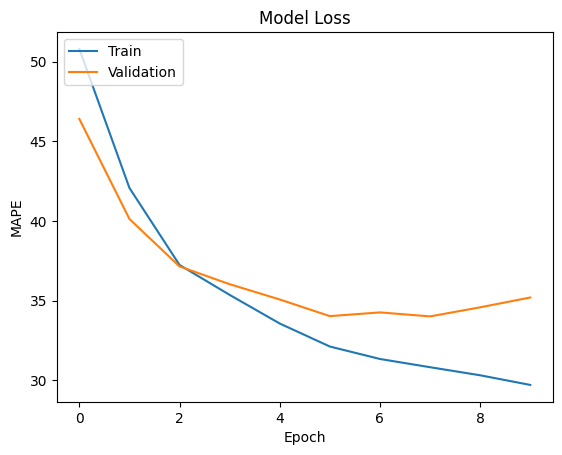

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='linear'))
# create Adam optimizer with a learning rate of 0.001
adam = Adam(learning_rate=0.01)


model.compile(loss=smape_loss, optimizer='adam')
# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 10, verbose=0, batch_size=32)

# assume X_new is the new data you want to make predictions on
y_pred = model.predict(X_test)


# plot training and validation loss over epochs
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                17344     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

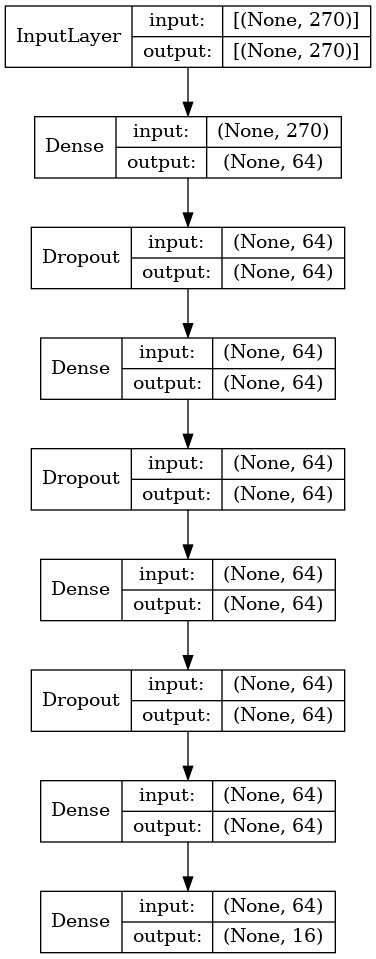

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=False)

In [ ]:
smape(y_test, y_pred)


updrs_1_plus_0_months     32.513010
updrs_2_plus_0_months     38.951881
updrs_3_plus_0_months     42.619179
updrs_4_plus_0_months     16.987409
updrs_1_plus_6_months     33.134750
updrs_2_plus_6_months     39.048110
updrs_3_plus_6_months     46.087545
updrs_4_plus_6_months     17.537710
updrs_1_plus_12_months    32.936941
updrs_2_plus_12_months    39.530288
updrs_3_plus_12_months    42.428008
updrs_4_plus_12_months    20.578584
updrs_1_plus_24_months    31.178168
updrs_2_plus_24_months    41.796580
updrs_3_plus_24_months    46.076431
updrs_4_plus_24_months    22.775597
dtype: float64

In [ ]:
df_avg =  smape(y_test, y_pred)

In [ ]:
(df_avg.updrs_1_plus_0_months + df_avg.updrs_1_plus_6_months + df_avg.updrs_1_plus_12_months + df_avg.updrs_1_plus_24_months )/4

32.440717090687315

In [ ]:
(df_avg.updrs_2_plus_0_months + df_avg.updrs_2_plus_6_months + df_avg.updrs_2_plus_12_months + df_avg.updrs_2_plus_24_months )/4

39.83171467368724

In [ ]:
(df_avg.updrs_3_plus_0_months + df_avg.updrs_3_plus_6_months + df_avg.updrs_3_plus_12_months + df_avg.updrs_3_plus_24_months )/4

44.302790768388306

In [ ]:
(df_avg.updrs_4_plus_0_months + df_avg.updrs_4_plus_6_months + df_avg.updrs_4_plus_12_months + df_avg.updrs_4_plus_24_months )/4

19.46982472066553

In [ ]:
avg_smape = np.mean(smape(y_test,y_pred))
avg_smape

33.295847726737335

In [ ]:
import pickle
# save scaler1 to a file using pickle
with open('scaler1.pkl', 'wb') as f:
    pickle.dump(scaler1, f)

with open('scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler_features, f)

In [ ]:
import amp_pd_peptide_310
import pickle
env = amp_pd_peptide_310.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

In [ ]:
target_list_sub = ['updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                   'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                   'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                   'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months']
# load scaler1 from file using pickle
with open('scaler1.pkl', 'rb') as f:
    scaler1 = pickle.load(f)
with open('scaler_features.pkl', 'rb') as f:
    scaler_features = pickle.load(f)

In [ ]:
uniprots_to_select2 = ['Q9UHG2', 'P05090', 'P41222', 'P02751', 'P01023', 'P02766',
                      'P01834', 'P02768', 'P02787', 'P02790', 'P01011', 'P02749',
                      'P02774', 'P02765', 'P01042', 'P01024', 'P10909', 'P02649',
                      'P07602', 'P02647', 'P01876', 'P06396', 'Q92520', 'P01009',
                      'P23142', 'Q12805', 'O15240']

In [ ]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    sample_submission.loc[:,'rating'] =1
    Prot_Peptides_df = pd.merge(test_proteins, test_peptides, on = ['visit_id','UniProt'], how = 'left')
    Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','Peptide','PeptideAbundance']]

    df_filtered2 = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select2)]

    # apply log(x+1) transformation to columns
    df_filtered2[['PeptideAbundance']] = df_filtered2[['PeptideAbundance']].apply(lambda x: np.log1p(x))
    # standardization
    df_filtered2[['PeptideAbundance']] = scaler1.fit_transform(df_filtered2[['PeptideAbundance']])

    pca_features_list2 = []
    all_peptides2 = df_filtered2['Peptide'].unique()
    for visit_id in df_filtered2['visit_id'].unique():
        # Part 1: construct UniProt-Peptide Network for each visit_id
        p_df = df_filtered2[df_filtered2['visit_id'] == visit_id]
        # first, pivot the data so that the UniProt column becomes the index,
        # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
        pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
        # iterate over each UniProt and add missing peptides as columns with a value of 0
        for prot in pivoted.index:
            missing_peptides = set(all_peptides2) - set(pivoted.columns)
            for pep in missing_peptides:
                pivoted.loc[prot, pep] = 0

        # fill any remaining missing values with 0
        pivoted.fillna(0, inplace=True)
        # reset the index so that UniProt is a column again
        pivoted = pivoted.reset_index()
        # rename the index column to 'UniProt'
        pivoted.index.name = 'UniProt'
        # save the pivoted DataFrame to a new variable called `new_df`
        new_df = pivoted.copy(deep=True)

        # Part II: PCA feature extraction
        # fit and transform the data
        df1_pca = pca.fit_transform(new_df.iloc[:,1:])
        # flatten the array to one dimension
        df1_pca = np.array(df1_pca).flatten()
        # store the PCA features along with the visit_id in the list
        pca_features_list2.append({'visit_id': visit_id, 'pca_features': df1_pca})

    # construct a dataframe from the PCA features list
    df_pca_features2 = pd.DataFrame(pca_features_list2)
    # split the pca_features column into multiple columns
    PP_features2 = pd.concat([df_pca_features2.drop('pca_features', axis=1), df_pca_features2['pca_features'].apply(pd.Series)], axis=1)

    col_fea=PP_features2.columns[1:]
    X_test_sub = scaler_features.transform(PP_features2[col_fea])
    # model.predict(tf.convert_to_tensor(X_test_sub)).astype(int)

    test_result = np.maximum(model.predict(tf.convert_to_tensor(X_test_sub)),0) #.astype(int)
    # Create a new DataFrame with the visit_id and predicted target variables
    result_df = pd.DataFrame({'visit_id': PP_features2['visit_id']})
    for i in range(16):
        result_df[target_list_sub[i]]=test_result[:,i].item()

    # Create a new DataFrame to store the predictions
    predictions = pd.DataFrame()
    # Generate a prediction_id for each combination of visit_id and column name
    for col in result_df.columns[1:]:
        predictions = predictions.append(result_df[['visit_id', col]].rename(columns={col: 'rating'}).assign(prediction_id=lambda x: x['visit_id'] + '_' + col))

    predictions2 = sample_submission[['prediction_id', 'rating']].copy(deep=True) # pd.DataFrame()
    for i, row in predictions.iterrows():
        prediction_id = row['prediction_id']
        rating = row['rating']
        #sample_submission.loc[sample_submission['prediction_id'] == prediction_id, 'rating'] = np.round(rating).astype(int)
        predictions2.loc[predictions2['prediction_id'] == prediction_id, 'rating'] = rating # np.round(rating).astype(int)

    env.predict(predictions2)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 37ms/step
